In [91]:
import pandas as pd
import geopandas as gpd
from osgeo import gdal
from osgeo import ogr
import os

### Read soil vector data and approximate study area boundaries

Make sure the study area boundaries are slightly larger than the exact area you will be modelling

In [92]:
#read soils map 
src_path=r'W:\VUB\Publications\swatplus_input_data_prep\faosoil\fao_soils\DSMW'
soils_gdf=gpd.read_file(os.path.join(src_path,'DSMW.shp'))

#read area of interest
roa_gdf=gpd.read_file(r'w:\VUB\Publications\swatplus_input_data_prep\nyando_shp\kenya_nyando_basin_boundary.shp')

#set shapefiles to common coordinate reference system
soils_gdf.crs = "EPSG:4326"
roa_gdf.crs="EPSG:4326"

#### Read user soil table

In [94]:
#read the user soil file containing the physical properties of the soil as dataframe
user_soil=pd.read_excel(r"W:\VUB\Publications\swatplus_input_data_prep\faosoil\usersoil_fao.xlsx")

In [95]:
#the soils geodataframe and the soils dataframe should have two common columns: a code and soil name column
#for the above case, the SEQN and SNAM in the dataframe (user_soil) and the SNUM and FAOSOIL in the geodataframe (soils_gdf)
#make sure the contents of these files match in both datasets
#test for instance unit 432

user_soil[user_soil['SEQN']==432]
soils_gdf[soils_gdf['SNUM']==432]

,SNUM,FAOSOIL,DOMSOI,PHASE1,PHASE2,MISCLU1,MISCLU2,PERMAFROST,CNTCODE,CNTNAME,SQKM,COUNTRY,geometry
26742,432,Ao68-1/2ab,Ao,01,None,None,None,None,215,TZ,214.0,TANZANIA,"POLYGON ((38.11572 -7.24074, 38.12970 -7.14404..."
26817,432,Ao68-1/2ab,Ao,01,None,None,None,None,215,TZ,133.0,TANZANIA,"POLYGON ((38.08465 -7.48878, 38.08124 -7.48642..."
26935,432,Ao68-1/2ab,Ao,01,None,None,None,None,215,TZ,2560.0,TANZANIA,"POLYGON ((37.89399 -7.70298, 37.89719 -7.70930..."
27150,432,Ao68-1/2ab,Ao,01,None,None,None,None,215,TZ,452.0,TANZANIA,"POLYGON ((38.74762 -8.33211, 38.75088 -8.34467..."
27324,432,Ao68-1/2ab,Ao,01,None,None,None,None,215,TZ,452.0,TANZANIA,"POLYGON ((38.47931 -8.93684, 38.51463 -8.98204..."


#### Clip soils vector to set boundaries of study area

<AxesSubplot:>

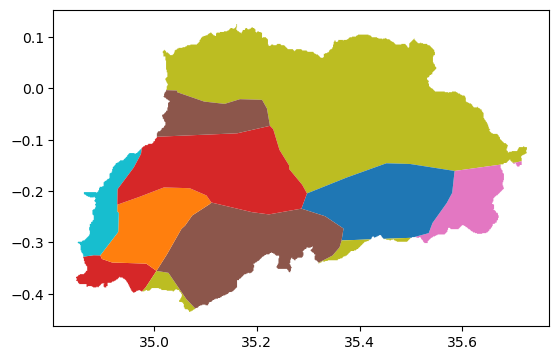

In [96]:
#clip soils shapefile to study area
roa_soils=soils_gdf.clip(roa_gdf)

#plot the soils of the study area and color according to the FAOSOIL column
roa_soils.plot(column='FAOSOIL')

### Convert roa soils to raster
Project to UTM coordinates according to region

In [97]:
#project roa_soils map to relevant UTM coordinate system
roa_soils_UTM=roa_soils.to_crs('EPSG:32637')

#### Prepare data for export

In [98]:
#create path and export outputs
os.chdir(r'W:\VUB\Publications\swatplus_input_data_prep')
def create_path(folder_name):
    parent_dir =os.getcwd() #path to parent folder
    out_folder = folder_name
    out_path = os.path.join(parent_dir, out_folder)
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    print("Your outputs will be written to:", out_path)
    
    return out_path

#create a folder to save outputs
outpath=create_path('nyando_soils')

Your outputs will be written to: W:\VUB\Publications\swatplus_input_data_prep\nyando_soils


#### Rasterize soils shapefile

In [100]:
#export roa soils vector data as GeoTiff
from geocube.api.core import make_geocube

soils_roa_grid= make_geocube(vector_data=roa_soils_UTM, measurements=["SNUM"], resolution=(-10, 10)) #for most crs negative comes first in resolution

#define path to raster
soils_roa_grid.rio.to_raster((os.path.join(outpath,'soils_roa.tif')),compress='DEFLATE', bigtiff='YES')

#### Create soils look up and user soils for study area

In [104]:
#Extract soils of the roa from the soils properties dataframe
#convert soil codes to list
roa_soil_code_list=roa_soils['SNUM'].to_list()

#extract the user soil for the catchment from the user soil dataframe
user_soil_catchment=user_soil[user_soil['SEQN'].isin(soils_lookup)]


In [106]:
soils_lookup_csv

,OBJECTID,MUID,SEQN,SNAM,S5ID,CMPPCT,NLAYERS,HYDGRP,SOL_ZMX,ANION_EXCL,...,SOL_PH1,SOL_PH2,SOL_PH3,SOL_PH4,SOL_PH5,SOL_PH6,SOL_PH7,SOL_PH8,SOL_PH9,SOL_PH10
56,57,NaN,76,I-R-bc-76,NaN,NaN,2,D,550.0,0.5,...,0,0,0,0,0,0,0,0,0,0
332,333,NaN,466,Bh14-3c-466,NaN,NaN,2,C,860.0,0.5,...,0,0,0,0,0,0,0,0,0,0
411,412,NaN,560,Fp10-2a-560,NaN,NaN,2,D,1000.0,0.5,...,0,0,0,0,0,0,0,0,0,0
429,430,NaN,582,Fr9-2a-582,NaN,NaN,2,C,1000.0,0.5,...,0,0,0,0,0,0,0,0,0,0
615,616,NaN,823,Ne29-2bc-823,NaN,NaN,2,C,940.0,0.5,...,0,0,0,0,0,0,0,0,0,0
636,637,NaN,848,Nh2-2c-848,NaN,NaN,2,C,830.0,0.5,...,0,0,0,0,0,0,0,0,0,0
725,726,NaN,960,Vp45-2-3a-960,NaN,NaN,2,C,910.0,0.5,...,0,0,0,0,0,0,0,0,0,0


#### Export user soil and soil look up tables

In [103]:
#extract soils look up from the user soil dataframe
soils_lookup=user_soil_catchment[['SEQN','SNAM']]
soils_lookup.columns=['SOIL_ID','NAME']

#Export outputs
soils_lookup.to_csv(os.path.join(outpath,'soils_lookup.csv'), index=False)
user_soil_catchment.to_csv(os.path.join(outpath,'user_soil_nyando.csv'), index=False)